# Initialize

In [1]:
from pytorch_grad_cam import GradCAM
import torch
from PIL import Image
import numpy as np
import cv2
import os
import open_clip

from tqdm import tqdm
from pytorch_grad_cam.utils.image import scale_cam_image
from utils import parse_xml_to_dict, scoremap2bbox
from clip_text import class_names#, imagenet_templates
import argparse
from torch import multiprocessing
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip

import types
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
import warnings
warnings.filterwarnings("ignore")

# Help functions

In [2]:
# -*- coding:UTF-8 -*-
from pytorch_grad_cam import GradCAM
import torch
from PIL import Image
import numpy as np
import cv2
import os
import open_clip

from tqdm import tqdm
from pytorch_grad_cam.utils.image import scale_cam_image
from utils import parse_xml_to_dict, scoremap2bbox
from clip_text import class_names#, imagenet_templates
import argparse
from torch import multiprocessing
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip

import types
import sys
sys.path.insert(0, '/home/zhang.13617/Desktop/BioCLIP_visualize')
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
import warnings
warnings.filterwarnings("ignore")

def reshape_transform(tensor, height=None, width=None):
    tensor = tensor.permute(1, 0, 2)  # Shape: (batch_size, seq_len, hidden_dim)
    seq_len = tensor.size(1)
    batch_size = tensor.size(0)
    hidden_dim = tensor.size(2)
    n_tokens = seq_len - 1  # Exclude the first token (e.g., [CLS] token)

    if height is not None and width is not None:
        if height * width != n_tokens:
            raise ValueError(f"Provided height ({height}) and width ({width}) do not multiply to n_tokens ({n_tokens})")
    elif height is not None:
        if n_tokens % height != 0:
            raise ValueError(f"Cannot reshape: n_tokens ({n_tokens}) is not divisible by provided height ({height})")
        width = n_tokens // height
    elif width is not None:
        if n_tokens % width != 0:
            raise ValueError(f"Cannot reshape: n_tokens ({n_tokens}) is not divisible by provided width ({width})")
        height = n_tokens // width
    else:
        # Automatically determine height and width
        height = int(n_tokens ** 0.5)
        while n_tokens % height != 0 and height > 1:
            height -= 1
        if height == 1 and n_tokens % height != 0:
            raise ValueError(f"Cannot automatically determine height and width for n_tokens ({n_tokens})")
        width = n_tokens // height

    result = tensor[:, 1:, :].reshape(batch_size, height, width, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # Shape: (batch_size, hidden_dim, height, width)
    return result



def zeroshot_classifier(classnames, templates, model):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates] #format with class
            texts = tokenizer(texts).to(device) #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights.t()

class ClipOutputTarget:
    def __init__(self, category):
        self.category = category
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform_resize(h, w):
    return Compose([
        Resize((h,w), interpolation=BICUBIC),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def img_ms_and_flip(img_path, ori_height, ori_width, scales=[1.0], patch_size=16):
    all_imgs = []
    for scale in scales:
        preprocess = _transform_resize(int(np.ceil(scale * int(ori_height) / patch_size) * patch_size), int(np.ceil(scale * int(ori_width) / patch_size) * patch_size))
        image = preprocess(Image.open(img_path))
        image_ori = image
        image_flip = torch.flip(image, [-1])
        all_imgs.append(image_ori)
        all_imgs.append(image_flip)
    return all_imgs


# Perfrom 

In [5]:
def perform(dataset_list, args, model, fg_text_features, cam):

    device_id = "cuda:1"
    device = torch.device(device_id)
    model = model.to(device)
    fg_text_features = fg_text_features.to(device)

    # 确保输出目录存在
    os.makedirs(args.cam_out_dir, exist_ok=True)

    for im_idx, img_path in enumerate(tqdm(dataset_list)):
        image_filename = os.path.basename(img_path)
        image = Image.open(img_path).convert("RGB")  
        ori_width, ori_height = image.size 

        # 进行多尺度和翻转增强（这里只使用第一个尺度）
        ms_imgs = img_ms_and_flip(img_path, ori_height, ori_width, scales=[1.0])
        ms_imgs = [ms_imgs[0]]  # 只使用第一个增强图像

        for aug_idx, img_tensor in enumerate(ms_imgs):
            # 添加批次维度并移动到设备
            img_tensor = img_tensor.unsqueeze(0).to(device)  # 假设 `img_ms_and_flip` 返回的是张量

            h, w = img_tensor.shape[-2], img_tensor.shape[-1]

            # 通过模型进行前向传播，获取图像特征和注意力权重
            image_features, attn_weight_list = model.encode_image(img_tensor, h, w)

            # 准备 DifferenceCAM 的输入张量
            # 假设 DifferenceCAM 需要 [image_features, fg_text_features, h, w]
            input_tensor = [image_features, fg_text_features, h, w]

            targets = None

            grayscale_cam, logits_per_image, attn_weight_last = cam(input_tensor=input_tensor,
                                                                    targets=targets,
                                                                    target_size=None)  
            # 提取批次中的第一个 CAM
            grayscale_cam = grayscale_cam[0, :]  # 形状：[H, W]

            # 将 CAM 缩放到原始图像大小
            grayscale_cam_highres = cv2.resize(grayscale_cam, (ori_width, ori_height))
            highres_cam = torch.tensor(grayscale_cam_highres)



            # 检查注意力权重列表是否为空
            if not attn_weight_list:
                raise ValueError("attn_weight_list is empty.")

            # 处理注意力权重
            # 假设 attn_weight_list 是一个张量列表
            attn_weight = [aw[:, 1:, 1:] for aw in attn_weight_list]  # 移除 CLS token 或类似的 tokens
            attn_weight = torch.stack(attn_weight, dim=0)[-8:]  # 取最后8个注意力权重
            attn_weight = torch.mean(attn_weight, dim=0)
            attn_weight = attn_weight[0].cpu().detach().float()  # 假设批次大小为1

            # 将 CAM 转换为边界框
            box, cnt = scoremap2bbox(scoremap=grayscale_cam, threshold=0.4, multi_contour_eval=True)

            # 创建关联掩码
            aff_mask = torch.zeros((grayscale_cam.shape[0], grayscale_cam.shape[1]))
            for i_ in range(cnt):
                x0_, y0_, x1_, y1_ = box[i_]
                aff_mask[y0_:y1_, x0_:x1_] = 1

            aff_mask = aff_mask.view(1, -1)  # 展平掩码
            aff_mat = attn_weight  # 形状：[n, n]

            # 归一化注意力矩阵
            trans_mat = aff_mat / torch.sum(aff_mat, dim=0, keepdim=True)
            trans_mat = trans_mat / torch.sum(trans_mat, dim=1, keepdim=True)

            # 迭代归一化
            for _ in range(2):
                trans_mat = trans_mat / torch.sum(trans_mat, dim=0, keepdim=True)
                trans_mat = trans_mat / torch.sum(trans_mat, dim=1, keepdim=True)
            trans_mat = (trans_mat + trans_mat.transpose(1, 0)) / 2

            # 矩阵乘法进行进一步细化
            for _ in range(1):
                trans_mat = torch.matmul(trans_mat, trans_mat)

            # 应用关联掩码
            trans_mat = trans_mat * aff_mask

            # 准备 CAM 进行细化
            cam_to_refine = torch.FloatTensor(grayscale_cam).view(-1, 1)  # 形状：[n, 1]

            # 应用转换矩阵进行 CAM 细化
            cam_refined = torch.matmul(trans_mat, cam_to_refine).reshape(h // 16, w // 16)
            cam_refined = cam_refined.cpu().numpy().astype(np.float32)

            # 将细化后的 CAM 缩放到原始图像大小
            cam_refined_highres = scale_cam_image([cam_refined], (ori_width, ori_height))[0]

            # 保存细化后的 CAM
            # 文件名包含两类的索引，以便区分是哪个类的差值
            output_filename = image_filename.replace('jpg', 'npy')

            np.save(os.path.join(args.cam_out_dir, output_filename),
                    {
                        "highres_cam": grayscale_cam_highres.astype(np.float32),
                        "attn_highres": cam_refined_highres.astype(np.float32),
                    })




In [6]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('--split_file', type=str, default='/home/zhang.13617/Desktop/bioclip/summer_tanager/train.txt')
    parser.add_argument('--cam_out_dir', type=str, default='/home/zhang.13617/Desktop/BioCLIP_visualize/cams')
    args, unknown = parser.parse_known_args()  

    device = "cuda:1"
    print(device)
    with open(args.split_file, 'r') as file:
        train_list = [line.strip() for line in file] 
    train_list = [line.strip() for line in train_list]
    model, preprocess, _ = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
    model = model.to(device)
    
    # 获取 tokenizer
    tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

    # 创建文本特征
    fg_text_features = zeroshot_classifier(class_names, ['a clean origami {}.'], model)

    # 设置目标层
    target_layers = [model.visual.transformer.resblocks[-1].ln_1]
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    # 执行主要功能
    perform(train_list, args, model, fg_text_features, cam)


cuda:1


  0%|          | 0/2 [00:00<?, ?it/s]

(tensor([[2.8781e-01, 4.8933e-01, 2.2268e-01, 1.7598e-05, 4.1958e-07, 1.6517e-04]],
       device='cuda:1', grad_fn=<SoftmaxBackward0>), tensor([[[3.6949e-03, 1.1485e-04, 7.8374e-05,  ..., 6.8357e-05,
          6.7270e-05, 7.2672e-05],
         [1.5646e-03, 1.8370e-04, 1.3784e-04,  ..., 1.3738e-04,
          1.3334e-04, 1.4404e-04],
         [1.3957e-03, 1.8534e-04, 1.5286e-04,  ..., 1.4202e-04,
          1.4718e-04, 1.4679e-04],
         ...,
         [1.0852e-03, 1.7279e-04, 1.5462e-04,  ..., 1.9061e-04,
          1.8955e-04, 1.6091e-04],
         [1.0760e-03, 1.9597e-04, 1.6788e-04,  ..., 1.9654e-04,
          2.2714e-04, 1.8984e-04],
         [9.9497e-04, 1.8747e-04, 1.6228e-04,  ..., 1.8660e-04,
          1.9705e-04, 2.0585e-04]]], device='cuda:1', grad_fn=<MeanBackward1>))
[1]


 50%|█████     | 1/2 [00:01<00:01,  1.33s/it]


ValueError: Provided height (60) and width (80) do not multiply to n_tokens (690)

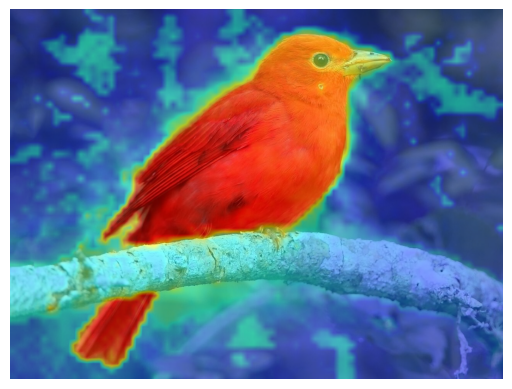

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_cam_on_image(img, cam, output_path=None):
    # Normalize CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Convert cam to uint8 type, range [0, 255]
    cam = np.uint8(255 * cam)

    # Create heatmap
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    # Ensure heatmap and img have the same size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Display overlay image
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Save overlay image if output_path is provided
    if output_path:
        cv2.imwrite(output_path, overlay)

def main(cam_npy_path, img_path, output_path=None):
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to read image {img_path}")
        return

    # Read CAM data
    try:
        cam_data = np.load(cam_npy_path, allow_pickle=True).item()
    except Exception as e:
        print(f"Error loading CAM npy file: {cam_npy_path}, error: {e}")
        return

    # Check if 'attn_highres' exists in the loaded npy data
    if "attn_highres" not in cam_data:
        print(f"Error: 'attn_highres' not found in {cam_npy_path}")
        return

    cam = cam_data.get("attn_highres")  # Get 'attn_highres' from npy file

    # Ensure 'cam' is valid
    if cam is None:
        print(f"Error: 'attn_highres' is None in {cam_npy_path}")
        return

    # If cam is a 3D array (multiple heatmaps), process each one
    if cam.ndim == 3:
        for idx in range(cam.shape[0]):
            cam_single = cam[idx]
            # Adjust output filename to include index
            output_path_idx = output_path.replace('.jpg', f'_{idx}.jpg')
            visualize_cam_on_image(img, cam_single, output_path_idx)
    else:
        visualize_cam_on_image(img, cam, output_path)

if __name__ == "__main__":
    cam_npy_dir = "/home/zhang.13617/Desktop/BioCLIP_visualize/cams"
    train_absolute_txt = "/home/zhang.13617/Desktop/bioclip/summer_tanager/train.txt"
    output_dir = "/home/zhang.13617/Desktop/BioCLIP_visualize/cams"
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get paths to .npy files sorted by filename
    cam_npy_paths = sorted([os.path.join(cam_npy_dir, f) for f in os.listdir(cam_npy_dir) if f.endswith('.npy')])

    # Read image absolute paths from train_absolute.txt
    with open(train_absolute_txt, 'r') as f:
        img_paths = [line.strip() for line in f.readlines()]

    # Iterate over CAM npy paths (process only available CAM files)
    for cam_npy_path in cam_npy_paths:
        # Try to find the corresponding image in img_paths by matching the base filename
        cam_filename = os.path.basename(cam_npy_path).replace('.npy', '')
        matching_img_paths = [img_path for img_path in img_paths if cam_filename in os.path.basename(img_path)]
        
        if not matching_img_paths:
            print(f"No matching image found for CAM file: {cam_npy_path}")
            continue

        # Use the first matching image path
        img_path = matching_img_paths[0]
        base_name = os.path.basename(img_path).replace('.jpg', '')

        # Generate output path
        output_filename = base_name + f'_output.jpg'
        output_path = os.path.join(output_dir, output_filename)

        # Call main function to visualize CAM on image
        main(cam_npy_path, img_path, output_path)